In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00


In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [140]:
def adf_test(df):
    test = adfuller(df)
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')

#MSE & R2
def mseAndR2(y_actual, y_smoothed):
    n = len(y_actual)
    mse = ((y_actual - y_smoothed)**2).mean()
    y_mean = y_actual.mean()
    ss_total = ((y_actual - y_mean)**2).sum()
    ss_residual = ((y_actual - y_smoothed)**2).sum()
    r_squared = 1 - (ss_residual / ss_total)

    return mse, r_squared

#AKF
def akf(series, lag):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series, lags=lag, ax=ax1)
    plot_pacf(series, lags=lag, ax=ax2)
    plt.show()

#Components plot
def plot_сomponents(dataframe, seasonal_period):
    result = seasonal_decompose(dataframe, model='additive', period=seasonal_period)
    plt.figure(figsize=(12, 7))
    plt.subplot(411)
    plt.plot(result.observed, label='Доходность')
    plt.legend()
    plt.subplot(412)
    plt.plot(result.trend, label='Тренд')
    plt.legend()
    plt.subplot(413)
    plt.plot(result.seasonal, label='Сезонность')
    plt.legend()
    plt.subplot(414)
    plt.plot(result.resid, label='Остатки', marker='o')
    plt.legend()
    plt.show()

def metrics(real, forecast):

    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4))

In [141]:
btc_df = pd.read_csv('btc.csv', index_col=['date'], parse_dates=['date']).drop(labels=['difficulty','hash-rate', 'market-price', 'trade-volume'], axis=1)
revenue = btc_df['2023-01-01':'2023-12-31']
revenue.head()

,miners-revenue
date,
2023-01-01,1.536867e+07
2023-01-02,1.552576e+07
2023-01-03,1.586050e+07
2023-01-04,1.643502e+07
2023-01-05,1.610212e+07


In [142]:
revenue = revenue * 0.0000001
revenue = revenue
revenue.describe()

,miners-revenue
count,365.000000
mean,2.847409
std,0.781850
min,1.536867
25%,2.445318
50%,2.694659
75%,2.904450
max,6.025453


<Axes: xlabel='date'>

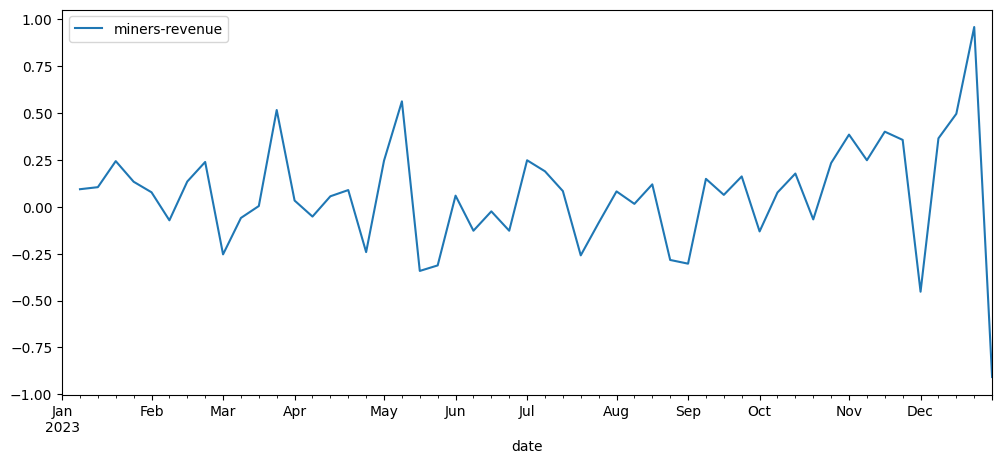

In [143]:
revenue.resample(rule='W').mean().diff().plot(figsize=(12,5))

In [144]:
adf_test(revenue)

adf:  1.7985343908103735
p-value:  0.9983461058111857
Critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
Ряд не стационарен


In [146]:
adf_test(revenue.diff().dropna()) # дифференцированрие первого порядка

adf:  -5.628169712424518
p-value:  1.105048064563114e-06
Critical values:  {'1%': -3.4493918438232525, '5%': -2.8699298018856574, '10%': -2.5712397066390458}
Ряд стационарен


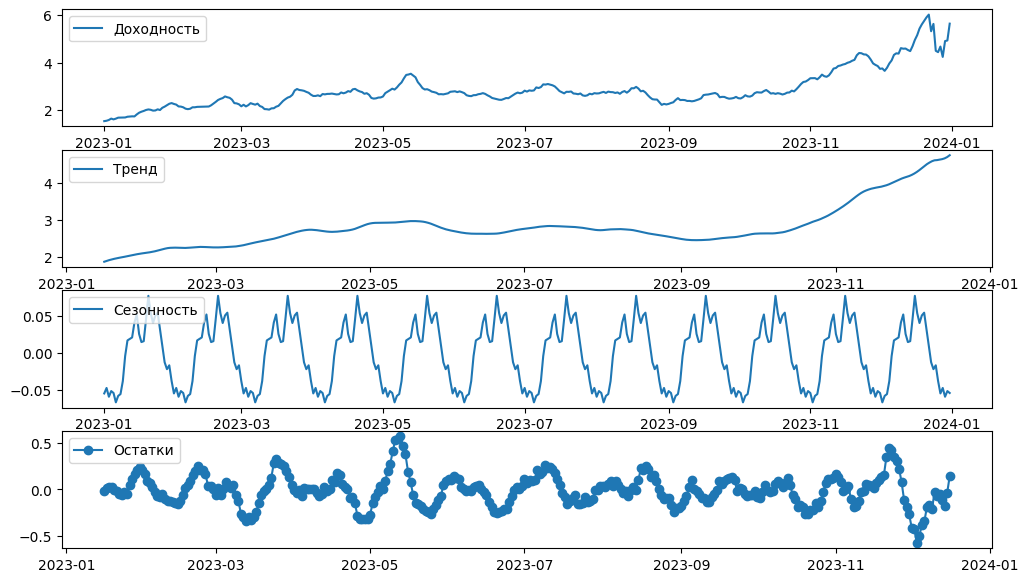

In [147]:
plot_сomponents(revenue, 30)

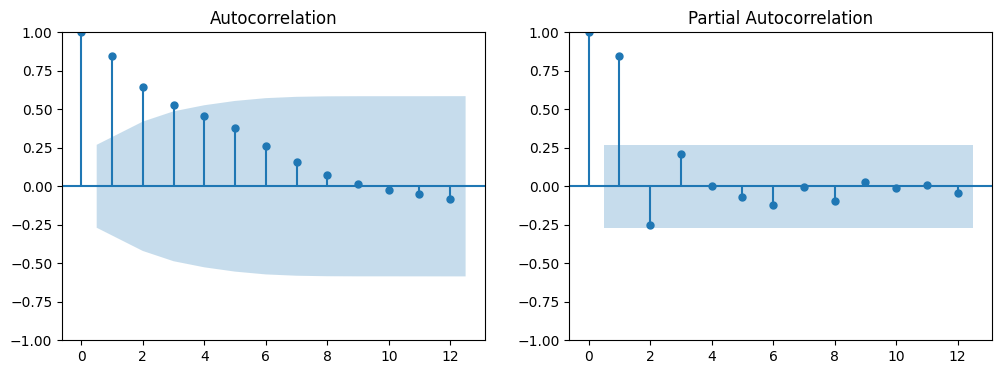

In [148]:
akf(revenue.resample(rule='W').mean(), 12)

In [ ]:
data_to_forecast = revenue#.resample(rule='W').mean()

In [ ]:
find_optimal_model = auto_arima(data_to_forecast, seasonal=True, m=12)
print(find_optimal_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(5, 1, 2)x(2, 0, [], 12)   Log Likelihood                 351.630
Date:                             Tue, 02 Apr 2024   AIC                           -681.260
Time:                                     08:51:32   BIC                           -638.391
Sample:                                 01-01-2023   HQIC                          -664.222
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.004      1.322      0.186      -0.003       0.013
ar.L1          0.0308      

In [ ]:
arima_model = ARIMA(data_to_forecast, order=(5,1,2), seasonal_order=(2,0,0,12))
arima_fit = arima_model.fit()
forecast = arima_fit.forecast(steps=65)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


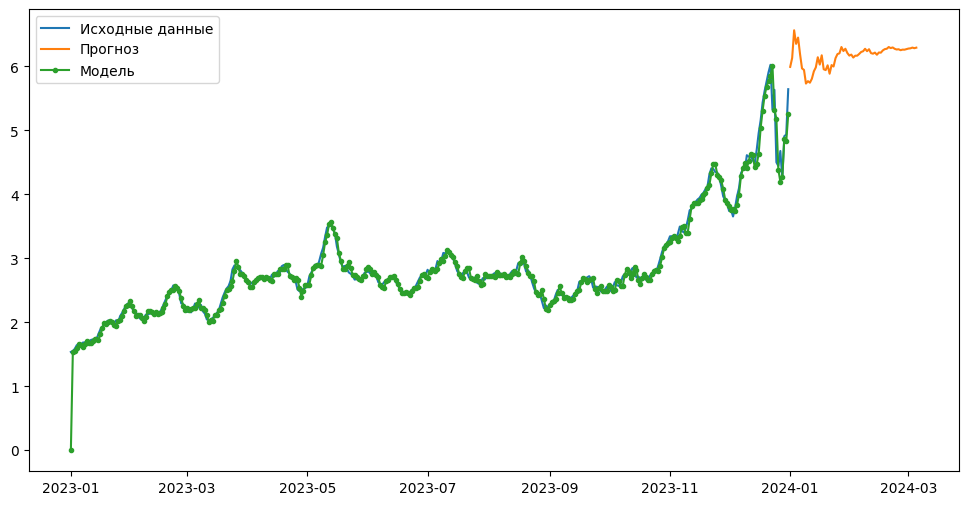

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data_to_forecast, label='Исходные данные')
plt.plot(forecast, label='Прогноз')
plt.plot(arima_fit.fittedvalues, label='Модель', marker='.')
plt.legend()
plt.show()

In [ ]:
forecast.describe()

count    65.000000
mean      6.165892
std       0.163700
min       5.732304
25%       6.129139
50%       6.210387
75%       6.270685
max       6.565211
Name: predicted_mean, dtype: float64

In [ ]:
metrics(data_to_forecast[300:], forecast)

MAD: 0.1114
MSE: 0.0311
MAPE: 0.0248
MPE: 0.0076
Стандартная ошибка: 0.1763


Коэф Сортино

In [217]:
def minmax(series, new_min=-1, new_max=1):
    min_val = series.min()
    max_val = series.max()
    normalized_series = new_min + ((series - min_val) * (new_max - new_min)) / (max_val - min_val)
    return normalized_series

def sortino_ratio(returns, risk_free_rate=0, target=0):
    downside_returns = returns - target
    downside_returns = downside_returns[downside_returns < 0]
    expected_return = returns.mean()
    downside_deviation = np.sqrt((expected_return ** 2)).mean()
    sortino_ratio = (expected_return - risk_free_rate) / downside_deviation
    print(sortino_ratio)

In [195]:
import json

with open('coins.json', 'r') as file:
    data = json.load(file)

coins_data = []

for coin, details in data['coins'].items():
    coin_name = coin
    coin_revenue = details.get('btc_revenue', None)
    coins_data.append({'coin': coin_name, 'revenue': coin_revenue})

df_coins = pd.DataFrame(coins_data)
df_coins.head()

,coin,revenue
0,Ravencoin,0.00003324
1,Zano,0.00003104
2,Nicehash-KawPow,0.00003396
3,Nirmata,0.0000327
4,Hoosat,0.00003158


In [209]:
coin_list = []
for index, row in df_coins.iterrows():
    coin_name = row['coin']
    coin_revenue = row['revenue']
    ratio = sortino_ratio(coin_revenue)
    coin_list.append({'coin': coin_name, 'sortino': ratio})

In [215]:
print(coin_list.sort_values(by='revenue', ascending=False))

                   coin     revenue
9               Vultaic  0.00005005
2       Nicehash-KawPow  0.00003396
0             Ravencoin  0.00003324
3               Nirmata   0.0000327
4                Hoosat  0.00003158
..                  ...         ...
27    Nicehash-IronFish  0.00000382
65                 Etho  0.00000361
66        HavenProtocol  0.00000267
67  Nicehash-Cuckatoo32  0.00000031
68               Cortex         0.0

[69 rows x 2 columns]
